# Shearflow Dataset Preprocessing

This notebook downloads a single shearflow simulation from the Polymathic AI "The Well" benchmark and preprocesses it into 1D spatial profiles for stencil learning.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/natrask/ENM5320-2026/blob/main/shearflow_project/shearflow_preprocessing.ipynb)

In [1]:
# Install required packages
import subprocess
import sys

# Install the_well package for dataset access, plus dependencies
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "the-well", "numpy", "matplotlib"])

0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path
from the_well.data import WellDataset
from the_well.utils.download import well_download

## Step 1: User Input - Select Reynolds and Schmidt Numbers

Specify which case to download:
- **Reynolds numbers**: 1e4, 5e4, 1e5, 5e5
- **Schmidt numbers**: 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0
- **Initial condition index**: 0-39 (40 different initial conditions per parameter combination)

For this exercise, we'll download and process a single case. Edit the parameters below:

In [3]:
# USER INPUT: Specify the case to download
Re = 5e5  # Reynolds number: 1e4, 5e4, 1e5, 5e5
Sc = 2e-1  # Schmidt number: 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0
ic_index = 0  # Initial condition index: 0-39

# Validate inputs
valid_Re = [1e4, 5e4, 1e5, 5e5]
valid_Sc = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]

assert Re in valid_Re, f"Reynolds number must be one of {valid_Re}"
assert Sc in valid_Sc, f"Schmidt number must be one of {valid_Sc}"
assert 0 <= ic_index < 40, "Initial condition index must be between 0 and 39"

print(f"Configuration:")
print(f"  Reynolds number (Re): {Re}")
print(f"  Schmidt number (Sc): {Sc}")
print(f"  Initial condition: {ic_index}")

Configuration:
  Reynolds number (Re): 500000.0
  Schmidt number (Sc): 0.2
  Initial condition: 0


## Step 2: Download Dataset from The Well using API - DONT RUN THIS UNLESS YOU HAVE 500gb AVAILABLE!

This notebook uses the `well_download` function from the official `the_well` package to automatically download and organize the shear_flow dataset. No manual download required!

**Important**: The notebook downloads directly to `C:/temp/datasets` to avoid OneDrive I/O issues. This ensures fast HDF5 file access.

In [5]:
# Download dataset and prepare to load the HDF5 file
import math
from pathlib import Path

# Download directly to C:/temp to avoid OneDrive I/O issues
base_path = Path("C:/temp/datasets/datasets")
base_path.mkdir(parents=True, exist_ok=True)

data_dir = base_path / "shear_flow" / "data" / "train"

In [ ]:
# Check if dataset exists AND is complete (not just empty files)
def check_dataset_complete(data_dir):
    """Check if dataset is fully downloaded (not just placeholder files)"""
    if not data_dir.exists():
        return False, 0, 0, 0
    
    hdf5_files = list(data_dir.glob("*.hdf5"))
    if len(hdf5_files) == 0:
        return False, 0, 0, 0
    
    # Check ALL files - every single one must be complete
    total_size = 0
    complete_files = 0
    incomplete_files = []
    
    for f in hdf5_files:
        size_gb = f.stat().st_size / (1024**3)
        total_size += size_gb
        if size_gb > 10.0:  # Each file should be >10 GB to be considered complete
            complete_files += 1
        else:
            incomplete_files.append(f"{f.name}: {size_gb:.2f} GB")
    
    # ALL files must be complete - if any are incomplete, download is not done
    total_files = len(hdf5_files)
    is_complete = (complete_files == total_files) and (total_files > 0)
    
    return is_complete, complete_files, total_size, total_files

is_complete, complete_files, total_size, total_files = check_dataset_complete(data_dir)

# Download if incomplete or missing
if not is_complete:
    if complete_files > 0:
        print(f"⚠ INCOMPLETE DOWNLOAD DETECTED:")
        print(f"  Complete files: {complete_files}/{total_files}")
        print(f"  Incomplete files: {total_files - complete_files}")
        print(f"  Total size so far: {total_size:.2f} GB")
        print(f"  Resuming download to complete ALL files...")
    else:
        print("Dataset not found locally. Downloading FULL shear_flow dataset...")
    
    print(f"Download target: {base_path.parent}")
    print("This may take 15-30 minutes depending on your connection...")
    print()
    
    import time
    start_time = time.time()
    
    print("Starting download with well_download()...")
    print(f"  Dataset: shear_flow")
    print(f"  Split: train")
    print(f"  Target: {base_path.parent}")
    print()
    print("Note: The download appears silent but IS working.")
    print("      Large files (16GB each) take time to transfer.")
    print()
    
    # Download the entire shear_flow dataset
    well_download(
        base_path=str(base_path.parent),
        dataset="shear_flow",
        split="train"
    )
    
    elapsed = time.time() - start_time
    print()
    print(f"✓ Download complete! (took {elapsed/60:.1f} minutes)")
    print()
    
    # Verify download
    if data_dir.exists():
        files = list(data_dir.glob("*.hdf5"))
        print(f"✓ Found {len(files)} HDF5 files in {data_dir}")
        total_size = sum(f.stat().st_size for f in files) / (1024**3)
        print(f"  Total size: {total_size:.2f} GB")
    else:
        print(f"⚠ Warning: Expected directory not found: {data_dir}")
    print()
else:
    print(f"✓ Dataset already exists at {data_dir}")
    files = list(data_dir.glob("*.hdf5"))
    print(f"  Found {len(files)} HDF5 files")
    print()


⚠ INCOMPLETE DOWNLOAD DETECTED:
  Complete files: 2/14
  Incomplete files: 12
  Total size so far: 30.08 GB
  Resuming download to complete ALL files...
Download target: C:\temp\datasets
This may take 15-30 minutes depending on your connection...

Starting download with well_download()...
  Dataset: shear_flow
  Split: train
  Target: C:\temp\datasets

Note: The download appears silent but IS working.
      Large files (16GB each) take time to transfer.



In [6]:
# Format filename components to match actual files
if Re >= 1000:
    Re_exp = int(math.log10(Re))
    Re_mantissa = int(Re / (10 ** Re_exp))
    Re_str = f"{Re_mantissa}e{Re_exp}"
else:
    Re_str = f"{int(Re)}"

if Sc >= 1.0:
    Sc_exp = int(math.log10(Sc))
    Sc_mantissa = int(Sc / (10 ** Sc_exp))
    Sc_str = f"{Sc_mantissa}e{Sc_exp}"
else:
    Sc_exp = int(math.floor(math.log10(Sc)))
    Sc_mantissa = int(Sc / (10 ** Sc_exp))
    Sc_str = f"{Sc_mantissa}e{Sc_exp}"

# Find matching file
filename_pattern = f"*Reynolds_{Re_str}_Schmidt_{Sc_str}.hdf5"
matching_files = list(data_dir.glob(filename_pattern))

if not matching_files:
    raise FileNotFoundError(f"No file found matching pattern: {filename_pattern}")

hdf5_file = matching_files[0]

print(f"Found HDF5 file: {hdf5_file.name}")
print(f"\nPreparing to load data (this may take a minute for large files)...")
print(f"File size: {hdf5_file.stat().st_size / (1024**3):.2f} GB")

Found HDF5 file: shear_flow_Reynolds_5e5_Schmidt_2e-1.hdf5

Preparing to load data (this may take a minute for large files)...
File size: 15.63 GB


## Step 3: Extract Tracer Field and Compute 1D Profiles

The WellDataset automatically downloads only the files matching your specified Reynolds and Schmidt numbers, keeping the download small.

In [7]:
# Load tracer data directly from HDF5 file
import h5py

print("Opening HDF5 file and exploring structure...")

with h5py.File(hdf5_file, 'r') as f:
    print(f"Top-level keys: {list(f.keys())}")
    print()
    
    # Explore each group
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Group):
            print(f"Group '{key}' contains: {list(item.keys())[:5]}")  # Show first 5
            # Check first item
            if len(item.keys()) > 0:
                first_key = list(item.keys())[0]
                first_item = item[first_key]
                if isinstance(first_item, h5py.Dataset):
                    print(f"  Example: {first_key} -> shape={first_item.shape}, dtype={first_item.dtype}")
        elif isinstance(item, h5py.Dataset):
            print(f"Dataset '{key}': shape={item.shape}, dtype={item.dtype}")
        print()
    
    # Load tracer from t0_fields
    print(f"Loading tracer for ic_index={ic_index}...")
    tracer_data_all = f['t0_fields']['tracer'][...]
    print(f"Full tracer shape: {tracer_data_all.shape} (ic, time, y, x)")
    
    # Select the specific initial condition
    tracer_data = tracer_data_all[ic_index, :, :, :]
    print(f"Selected ic_index={ic_index}: shape={tracer_data.shape}")
    
    # Load actual coordinates from dimensions group
    t = f['dimensions']['time'][...]
    y_coords = f['dimensions']['y'][...]
    x_coords = f['dimensions']['x'][...]
    
    print(f"\nLoaded coordinates from file:")
    print(f"  time: {t.shape}, range=[{t[0]:.2f}, {t[-1]:.2f}]")
    print(f"  y: {y_coords.shape}, range=[{y_coords[0]:.2f}, {y_coords[-1]:.2f}]")
    print(f"  x: {x_coords.shape}, range=[{x_coords[0]:.2f}, {x_coords[-1]:.2f}]")

# Assign coordinates for later use
n_time, n_y, n_x = tracer_data.shape
print(f"\nCoordinate lengths: y_coords={len(y_coords)}, x_coords={len(x_coords)}")
print(f"Data shape: time={n_time}, dim2={n_y}, dim3={n_x}")

# Match coordinates to data dimensions
# The HDF5 file has dimensions stored as (time, y, x) but coordinates might be swapped
if len(y_coords) == n_y and len(x_coords) == n_x:
    y = y_coords
    x = x_coords
    print("✓ Coordinates match data shape")
elif len(y_coords) == n_x and len(x_coords) == n_y:
    # Coordinates are swapped in the file
    y = x_coords
    x = y_coords
    print("⚠ Swapped x and y coordinates to match data shape")
else:
    raise ValueError(f"Coordinate mismatch: y_coords={len(y_coords)}, x_coords={len(x_coords)}, data shape=({n_y}, {n_x})")

print(f"\nFinal tracer data:")
print(f"  Shape: {tracer_data.shape}")
print(f"  Time steps: {n_time}")
print(f"  Spatial grid: {n_y} × {n_x}")
print(f"  Time range: t ∈ [{t[0]:.2f}, {t[-1]:.2f}]")
print(f"  Spatial domain: y ∈ [{y[0]:.2f}, {y[-1]:.2f}] (len={len(y)}), x ∈ [{x[0]:.2f}, {x[-1]:.2f}] (len={len(x)})")

Opening HDF5 file and exploring structure...
Top-level keys: ['boundary_conditions', 'dimensions', 'scalars', 't0_fields', 't1_fields', 't2_fields']

Group 'boundary_conditions' contains: ['x_periodic', 'y_periodic']

Group 'dimensions' contains: ['time', 'x', 'y']
  Example: time -> shape=(200,), dtype=float64

Group 'scalars' contains: ['Reynolds', 'Schmidt']
  Example: Reynolds -> shape=(), dtype=float32

Group 't0_fields' contains: ['pressure', 'tracer']
  Example: pressure -> shape=(32, 200, 256, 512), dtype=float32

Group 't1_fields' contains: ['velocity']
  Example: velocity -> shape=(32, 200, 256, 512, 2), dtype=float32

Group 't2_fields' contains: []

Loading tracer for ic_index=0...
Full tracer shape: (32, 200, 256, 512) (ic, time, y, x)
Selected ic_index=0: shape=(200, 256, 512)

Loaded coordinates from file:
  time: (200,), range=[0.00, 19.90]
  y: (512,), range=[0.00, 1.00]
  x: (256,), range=[0.00, 1.00]

Coordinate lengths: y_coords=512, x_coords=256
Data shape: time=200

In [8]:
# Diagnostic: Check dimensions
print("Dimension check:")
print(f"  x coordinate: len={len(x)}, range=[{x[0]:.3f}, {x[-1]:.3f}]")
print(f"  y coordinate: len={len(y)}, range=[{y[0]:.3f}, {y[-1]:.3f}]")
print(f"  tracer_data[0] shape: {tracer_data[0].shape}")
print(f"  tracer_data[0].T shape: {tracer_data[0].T.shape}")
print()
print("For contourf(X, Y, Z): Z must have shape (len(Y), len(X))")
print(f"  Expected Z shape: ({len(y)}, {len(x)})")
print(f"  Actual tracer_data[0] shape: {tracer_data[0].shape}")
print()

# The correct call should be contourf(x, y, Z) where Z.shape = (len(y), len(x))
if tracer_data[0].shape == (len(y), len(x)):
    print("✓ Original data matches: use contourf(x, y, tracer_data[t_idx])")
elif tracer_data[0].T.shape == (len(y), len(x)):
    print("✓ Transposed data matches: use contourf(x, y, tracer_data[t_idx].T)")
else:
    print("✗ Neither original nor transposed matches!")

Dimension check:
  x coordinate: len=512, range=[0.000, 1.000]
  y coordinate: len=256, range=[0.000, 1.000]
  tracer_data[0] shape: (256, 512)
  tracer_data[0].T shape: (512, 256)

For contourf(X, Y, Z): Z must have shape (len(Y), len(X))
  Expected Z shape: (256, 512)
  Actual tracer_data[0] shape: (256, 512)

✓ Original data matches: use contourf(x, y, tracer_data[t_idx])


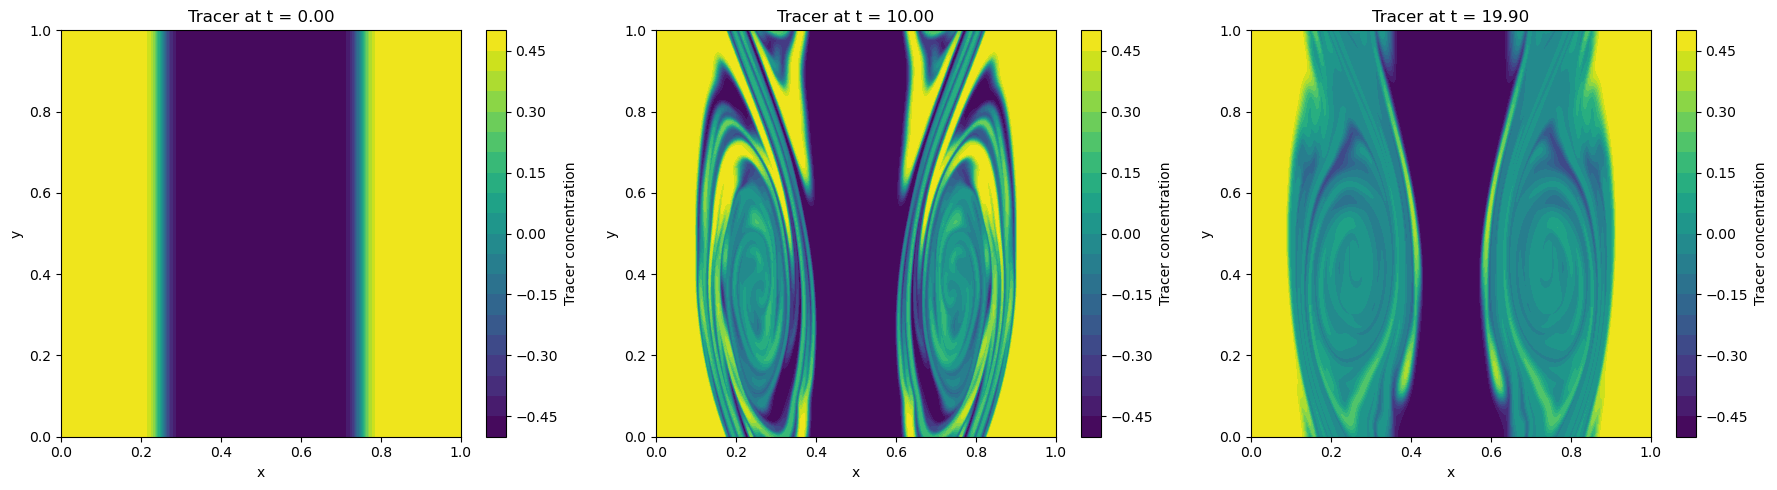

✓ Visualization saved as 'tracer_2d_snapshots.png'


In [9]:
# Visualize 2D tracer field at different time snapshots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Select time indices to visualize (spread across the simulation)
time_indices = [0, n_time//2, n_time-1]  # Start, middle, end

for idx, t_idx in enumerate(time_indices):
    ax = axes[idx]
    
    # Plot 2D tracer field (no transpose needed - shape is already correct)
    im = ax.contourf(x, y, tracer_data[t_idx, :, :], levels=20, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Tracer at t = {t[t_idx]:.2f}')
    plt.colorbar(im, ax=ax, label='Tracer concentration')

plt.tight_layout()
plt.savefig('tracer_2d_snapshots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved as 'tracer_2d_snapshots.png'")

## Step 5: Average Perpendicular to Density Gradient

The density gradient is in the y-direction (vertical). We average across x (horizontal) to obtain 1D spatial profiles $s(y, t)$ as a function of y and time.

In [10]:
# Average across y-direction to get 1D profiles
# tracer_data shape: (time=200, y=256, x=512)
# We average over axis=1 (y-direction) to get (time, x)
tracer_mean_1d = np.mean(tracer_data, axis=1)  # Mean profile
tracer_std_1d = np.std(tracer_data, axis=1)    # Std of residual

print(f"1D mean profile shape: {tracer_mean_1d.shape}")
print(f"1D std profile shape: {tracer_std_1d.shape}")
print(f"  Time steps: {tracer_mean_1d.shape[0]}")
print(f"  Spatial points (x): {tracer_mean_1d.shape[1]}")

# Compute anomalous diffusivity estimate
# For linear diffusion: ∂s/∂t = D ∂²s/∂y²
# We can estimate D from the rate of decay of tracer variance
variance_over_time = np.var(tracer_mean_1d, axis=1)
print(f"\nVariance statistics:")
print(f"  Initial variance: {variance_over_time[0]:.6f}")
print(f"  Final variance: {variance_over_time[-1]:.6f}")
print(f"  Decay rate: {variance_over_time[-1] / variance_over_time[0]:.6f}")

1D mean profile shape: (200, 512)
1D std profile shape: (200, 512)
  Time steps: 200
  Spatial points (x): 512

Variance statistics:
  Initial variance: 0.224984
  Final variance: 0.097105
  Decay rate: 0.431606


## Step 6: Visualize the 1D Profiles

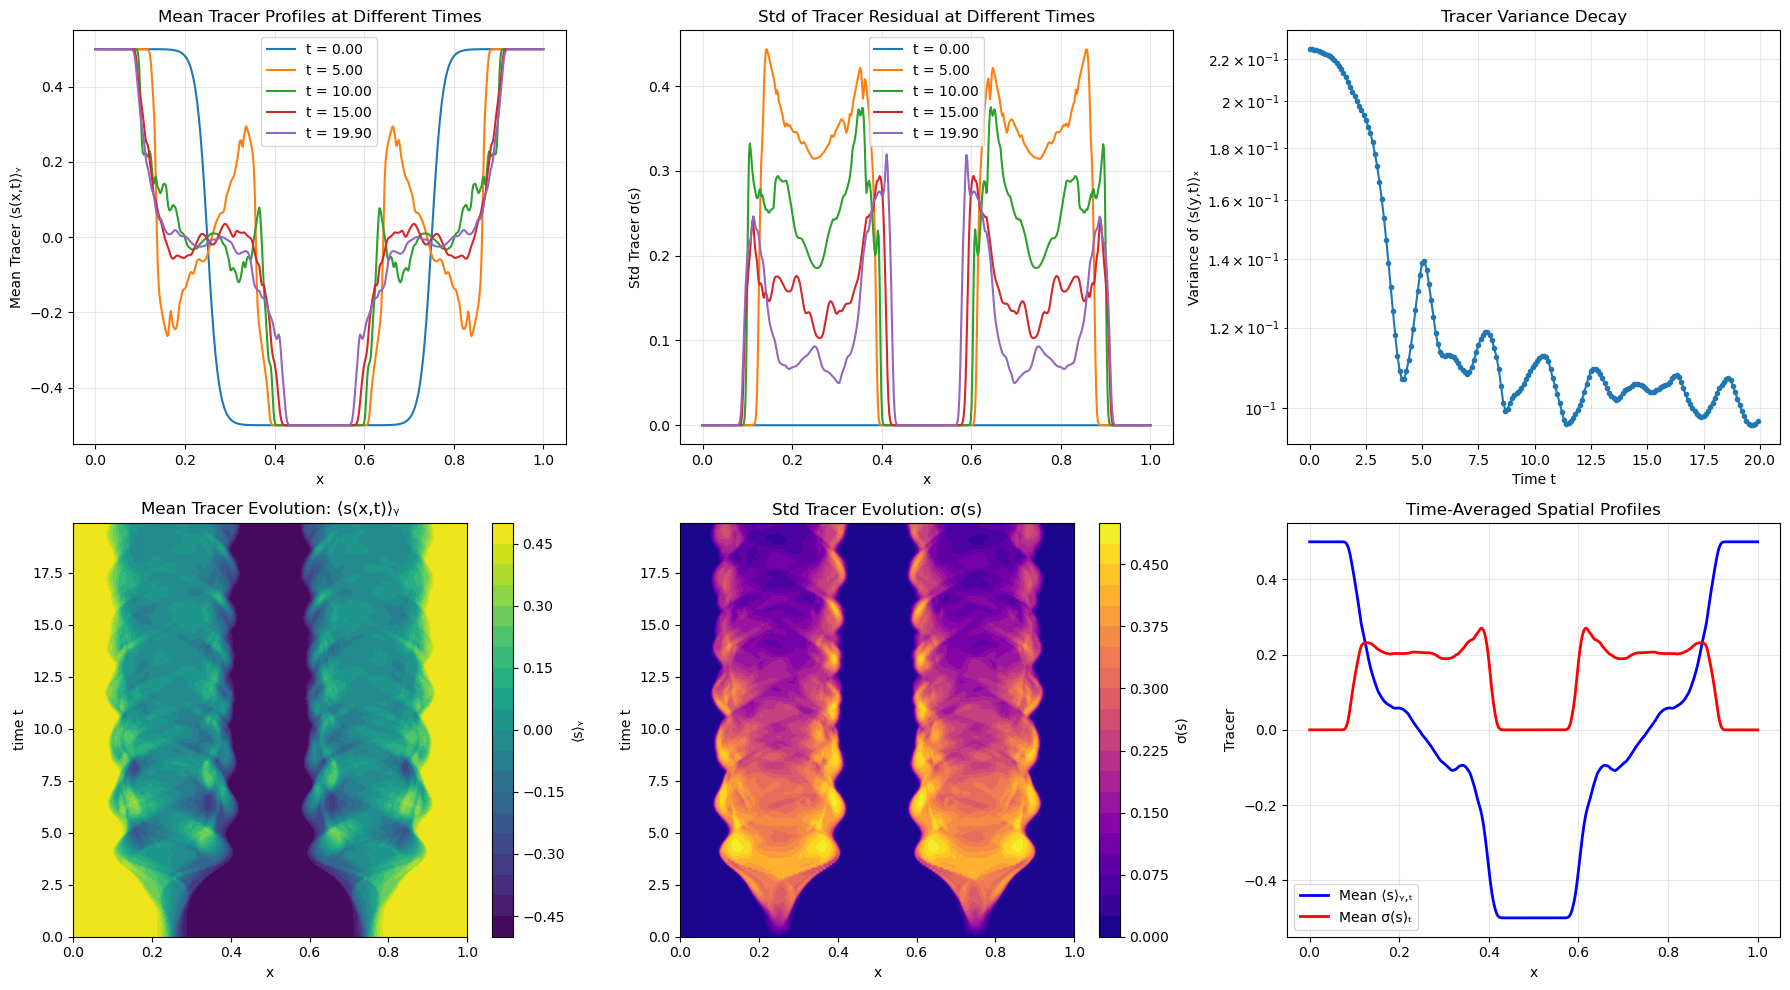

✓ Visualization saved as 'tracer_profiles.png'


In [11]:
# Visualize the 1D mean and std profiles over time
# tracer_mean_1d, tracer_std_1d shape: (time=200, y=512)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Mean tracer at different time snapshots
ax = axes[0, 0]
time_indices = [0, 50, 100, 150, n_time-1]
for t_idx in time_indices:
    ax.plot(x, tracer_mean_1d[t_idx, :], label=f't = {t[t_idx]:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('Mean Tracer ⟨s(x,t)⟩ᵧ')
ax.set_title('Mean Tracer Profiles at Different Times')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Std tracer at different time snapshots
ax = axes[0, 1]
for t_idx in time_indices:
    ax.plot(x, tracer_std_1d[t_idx, :], label=f't = {t[t_idx]:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('Std Tracer σ(s)')
ax.set_title('Std of Tracer Residual at Different Times')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Variance decay
ax = axes[0, 2]
ax.semilogy(t, variance_over_time, 'o-', markersize=3)
ax.set_xlabel('Time t')
ax.set_ylabel('Variance of ⟨s(y,t)⟩ₓ')
ax.set_title('Tracer Variance Decay')
ax.grid(True, alpha=0.3, which='both')

# Plot 4: Heatmap of mean tracer evolution
ax = axes[1, 0]
im = ax.contourf(x, t, tracer_mean_1d, levels=20, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('time t')
ax.set_title('Mean Tracer Evolution: ⟨s(x,t)⟩ᵧ')
plt.colorbar(im, ax=ax, label='⟨s⟩ᵧ')

# Plot 5: Heatmap of std tracer evolution
ax = axes[1, 1]
im = ax.contourf(x, t, tracer_std_1d, levels=20, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('time t')
ax.set_title('Std Tracer Evolution: σ(s)')
plt.colorbar(im, ax=ax, label='σ(s)')

# Plot 6: Time-averaged spatial profiles
ax = axes[1, 2]
mean_spatial = np.mean(tracer_mean_1d, axis=0)
std_spatial = np.mean(tracer_std_1d, axis=0)
ax.plot(x, mean_spatial, 'b-', linewidth=2, label='Mean ⟨s⟩ᵧ,ₜ')
ax.plot(x, std_spatial, 'r-', linewidth=2, label='Mean σ(s)ₜ')
ax.set_xlabel('x')
ax.set_ylabel('Tracer')
ax.set_title('Time-Averaged Spatial Profiles')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tracer_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved as 'tracer_profiles.png'")

## Extract and Process Velocity Field

Now extract the velocity field from the same HDF5 file and compute 1D profiles.

In [12]:
# Load velocity data from HDF5 file
print("Loading velocity field data...")

with h5py.File(hdf5_file, 'r') as f:
    # Check which group contains velocity - typically t1_fields
    print(f"Available field groups: {[k for k in f.keys() if 'fields' in k]}")
    
    # Velocity is typically in t1_fields (time derivatives)
    if 't1_fields' in f.keys():
        print(f"\nt1_fields contains: {list(f['t1_fields'].keys())}")
        
        # Load velocity components if available
        if 'velocity' in f['t1_fields'].keys():
            velocity_data_all = f['t1_fields']['velocity'][...]
            print(f"Full velocity shape: {velocity_data_all.shape}")
        else:
            print("\nVelocity field not found in t1_fields")
            print(f"Available fields: {list(f['t1_fields'].keys())}")
            velocity_data_all = None
    else:
        print("t1_fields group not found")
        velocity_data_all = None

if velocity_data_all is not None:
    # Select the specific initial condition
    velocity_data = velocity_data_all[ic_index, :, :, :, :]
    print(f"\nSelected ic_index={ic_index}: shape={velocity_data.shape}")
else:
    print("Could not load velocity data")
    velocity_data = None

Loading velocity field data...
Available field groups: ['t0_fields', 't1_fields', 't2_fields']

t1_fields contains: ['velocity']
Full velocity shape: (32, 200, 256, 512, 2)

Selected ic_index=0: shape=(200, 256, 512, 2)


In [13]:
# Diagnostic: Explore velocity data structure in detail
if velocity_data_all is not None:
    print("Detailed velocity data structure:")
    print(f"  Full shape: {velocity_data_all.shape}")
    print(f"  After selecting ic={ic_index}: {velocity_data.shape}")
    print()
    
    # Try to understand the dimensions
    print("Attempting to identify dimensions:")
    dims = velocity_data.shape
    print(f"  Dimension 0 (expecting time): {dims[0]} (tracer has {n_time} timesteps)")
    print(f"  Dimension 1 (expecting 2 components): {dims[1]}")
    print(f"  Dimension 2 (expecting spatial): {dims[2]} (tracer has {n_y})")
    print(f"  Dimension 3 (expecting spatial): {dims[3]} (tracer has {n_x})")
    print()
    
    # Check if dimensions match tracer
    if dims[0] == n_time:
        print("✓ Dimension 0 matches time")
    if dims[2] == n_y and dims[3] == n_x:
        print("✓ Dimensions 2,3 match spatial dimensions")
    elif dims[1] == n_y and dims[2] == n_x:
        print("⚠ Spatial dimensions appear to be at positions 1,2 instead of 2,3")
        print("  This means velocity might be stored as [time, y, x, components]")
    
    # Check for alternative storage formats
    if dims[1] == n_y and dims[2] == n_x and dims[3] == 2:
        print("\n✓ Velocity stored as [time, y, x, 2] - components last")
        velocity_x = velocity_data[:, :, :, 0]  # x-component
        velocity_y = velocity_data[:, :, :, 1]  # y-component
        print(f"  Extracted velocity_x: {velocity_x.shape}")
        print(f"  Extracted velocity_y: {velocity_y.shape}")
    elif dims[1] == 2 and dims[2] == n_y and dims[3] == n_x:
        print("\n✓ Velocity stored as [time, 2, y, x] - components first")
        velocity_x = velocity_data[:, 0, :, :]
        velocity_y = velocity_data[:, 1, :, :]
        print(f"  Extracted velocity_x: {velocity_x.shape}")
        print(f"  Extracted velocity_y: {velocity_y.shape}")
    else:
        print("\n✗ Cannot determine velocity storage format")
        print(f"  Expected one of:")
        print(f"    - [time={n_time}, 2, y={n_y}, x={n_x}]")
        print(f"    - [time={n_time}, y={n_y}, x={n_x}, 2]")
        print(f"  Got: {velocity_data.shape}")
        velocity_x = None
        velocity_y = None
else:
    velocity_x = None
    velocity_y = None

Detailed velocity data structure:
  Full shape: (32, 200, 256, 512, 2)
  After selecting ic=0: (200, 256, 512, 2)

Attempting to identify dimensions:
  Dimension 0 (expecting time): 200 (tracer has 200 timesteps)
  Dimension 1 (expecting 2 components): 256
  Dimension 2 (expecting spatial): 512 (tracer has 256)
  Dimension 3 (expecting spatial): 2 (tracer has 512)

✓ Dimension 0 matches time
⚠ Spatial dimensions appear to be at positions 1,2 instead of 2,3
  This means velocity might be stored as [time, y, x, components]

✓ Velocity stored as [time, y, x, 2] - components last
  Extracted velocity_x: (200, 256, 512)
  Extracted velocity_y: (200, 256, 512)


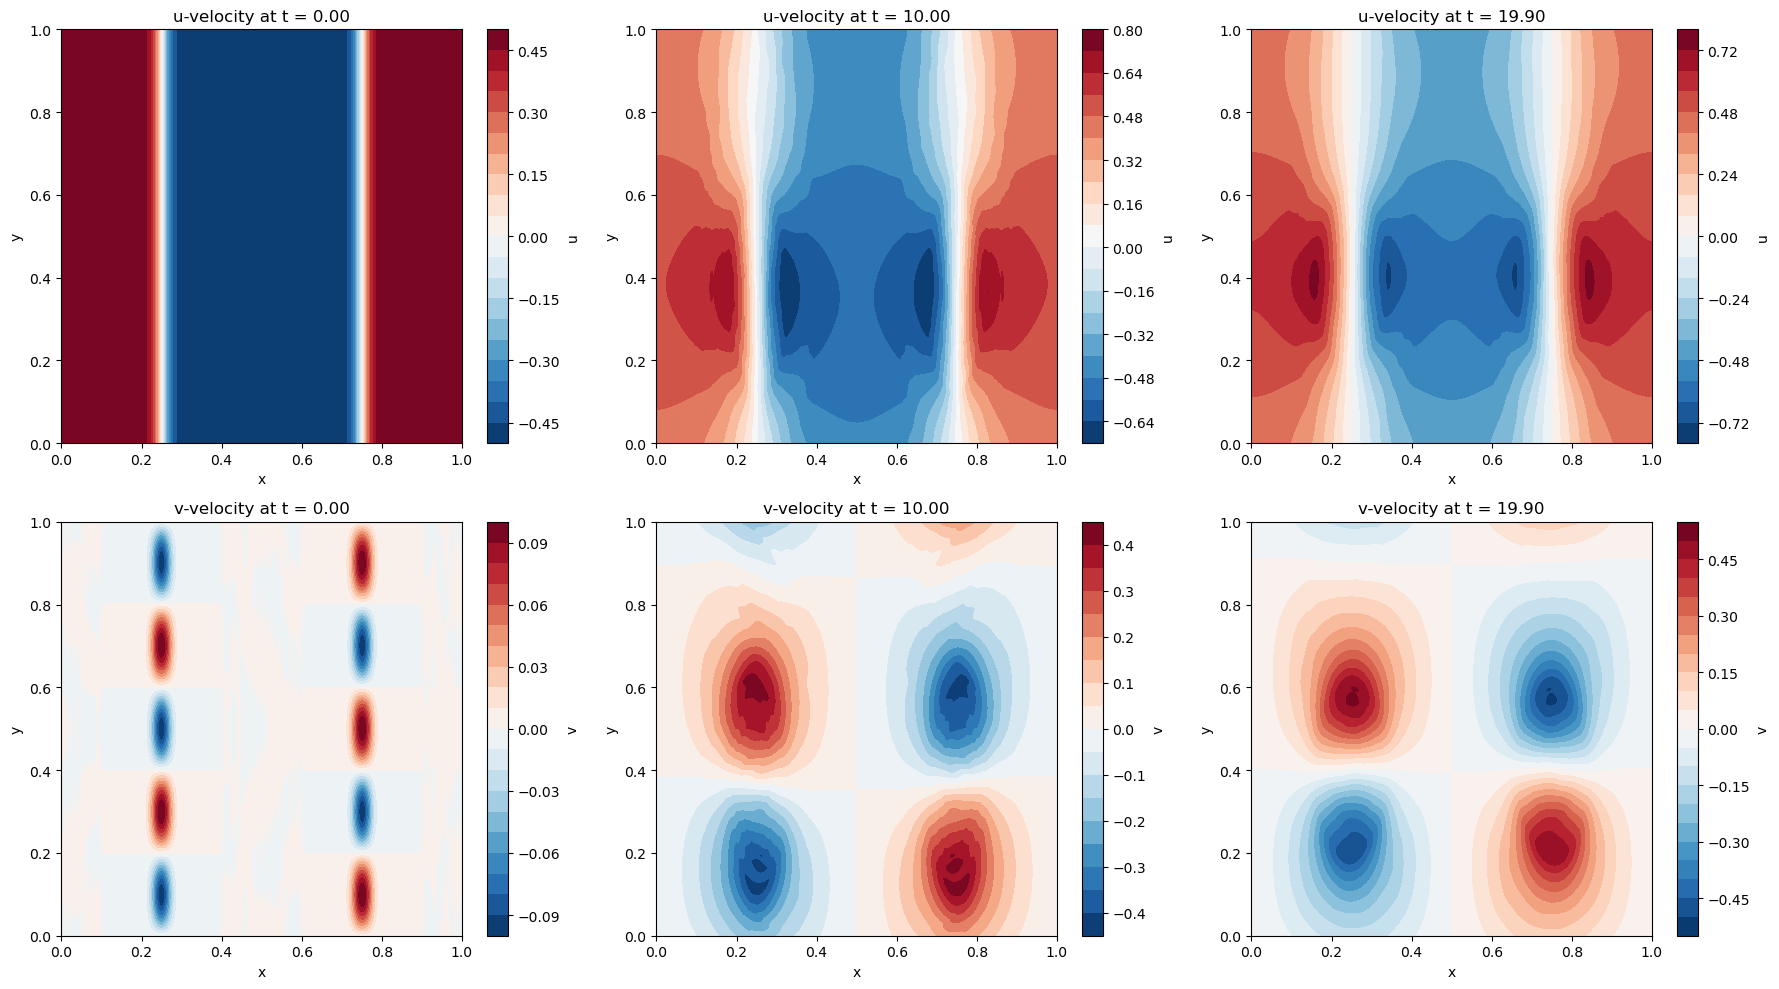

✓ Visualization saved as 'velocity_2d_snapshots.png'


In [14]:
# Visualize 2D velocity field at different time snapshots
if velocity_x is not None and velocity_y is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Select time indices to visualize
    time_indices = [0, n_time//2, n_time-1]
    
    # Row 1: u-component (x-velocity)
    for idx, t_idx in enumerate(time_indices):
        ax = axes[0, idx]
        im = ax.contourf(x, y, velocity_x[t_idx, :, :], levels=20, cmap='RdBu_r')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'u-velocity at t = {t[t_idx]:.2f}')
        plt.colorbar(im, ax=ax, label='u')
    
    # Row 2: v-component (y-velocity)
    for idx, t_idx in enumerate(time_indices):
        ax = axes[1, idx]
        im = ax.contourf(x, y, velocity_y[t_idx, :, :], levels=20, cmap='RdBu_r')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'v-velocity at t = {t[t_idx]:.2f}')
        plt.colorbar(im, ax=ax, label='v')
    
    plt.tight_layout()
    plt.savefig('velocity_2d_snapshots.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Visualization saved as 'velocity_2d_snapshots.png'")
else:
    print("Skipping visualization - velocity data not available")

In [15]:
# Average velocity components across y-direction to get 1D profiles
# velocity shape: (time=200, y=256, x=512) - same as tracer
if velocity_x is not None and velocity_y is not None:
    print("Computing 1D velocity profiles...")
    
    # For x-component (u) - average over y (axis=1)
    velocity_x_mean_1d = np.mean(velocity_x, axis=1)  # Mean profile
    velocity_x_std_1d = np.std(velocity_x, axis=1)    # Std of residual
    
    # For y-component (v) - average over y (axis=1)
    velocity_y_mean_1d = np.mean(velocity_y, axis=1)  # Mean profile
    velocity_y_std_1d = np.std(velocity_y, axis=1)    # Std of residual
    
    print(f"Velocity x-component (u):")
    print(f"  Mean profile shape: {velocity_x_mean_1d.shape}")
    print(f"  Std profile shape: {velocity_x_std_1d.shape}")
    print(f"\nVelocity y-component (v):")
    print(f"  Mean profile shape: {velocity_y_mean_1d.shape}")
    print(f"  Std profile shape: {velocity_y_std_1d.shape}")
    
    # Compute velocity magnitude
    velocity_mag = np.sqrt(velocity_x**2 + velocity_y**2)
    velocity_mag_mean_1d = np.mean(velocity_mag, axis=1)
    velocity_mag_std_1d = np.std(velocity_mag, axis=1)
    
    print(f"\nVelocity magnitude |v|:")
    print(f"  Mean profile shape: {velocity_mag_mean_1d.shape}")
    print(f"  Std profile shape: {velocity_mag_std_1d.shape}")
    
    # Statistics
    print(f"\nVelocity statistics:")
    print(f"  u range: [{velocity_x.min():.4f}, {velocity_x.max():.4f}]")
    print(f"  v range: [{velocity_y.min():.4f}, {velocity_y.max():.4f}]")
    print(f"  |v| range: [{velocity_mag.min():.4f}, {velocity_mag.max():.4f}]")
else:
    print("Skipping 1D profile computation - velocity data not available")
    velocity_x_mean_1d = None
    velocity_y_mean_1d = None
    velocity_mag_mean_1d = None

Computing 1D velocity profiles...
Velocity x-component (u):
  Mean profile shape: (200, 512)
  Std profile shape: (200, 512)

Velocity y-component (v):
  Mean profile shape: (200, 512)
  Std profile shape: (200, 512)

Velocity magnitude |v|:
  Mean profile shape: (200, 512)
  Std profile shape: (200, 512)

Velocity statistics:
  u range: [-0.8091, 0.8066]
  v range: [-0.6162, 0.6163]
  |v| range: [0.0002, 0.8138]


Creating velocity visualizations...


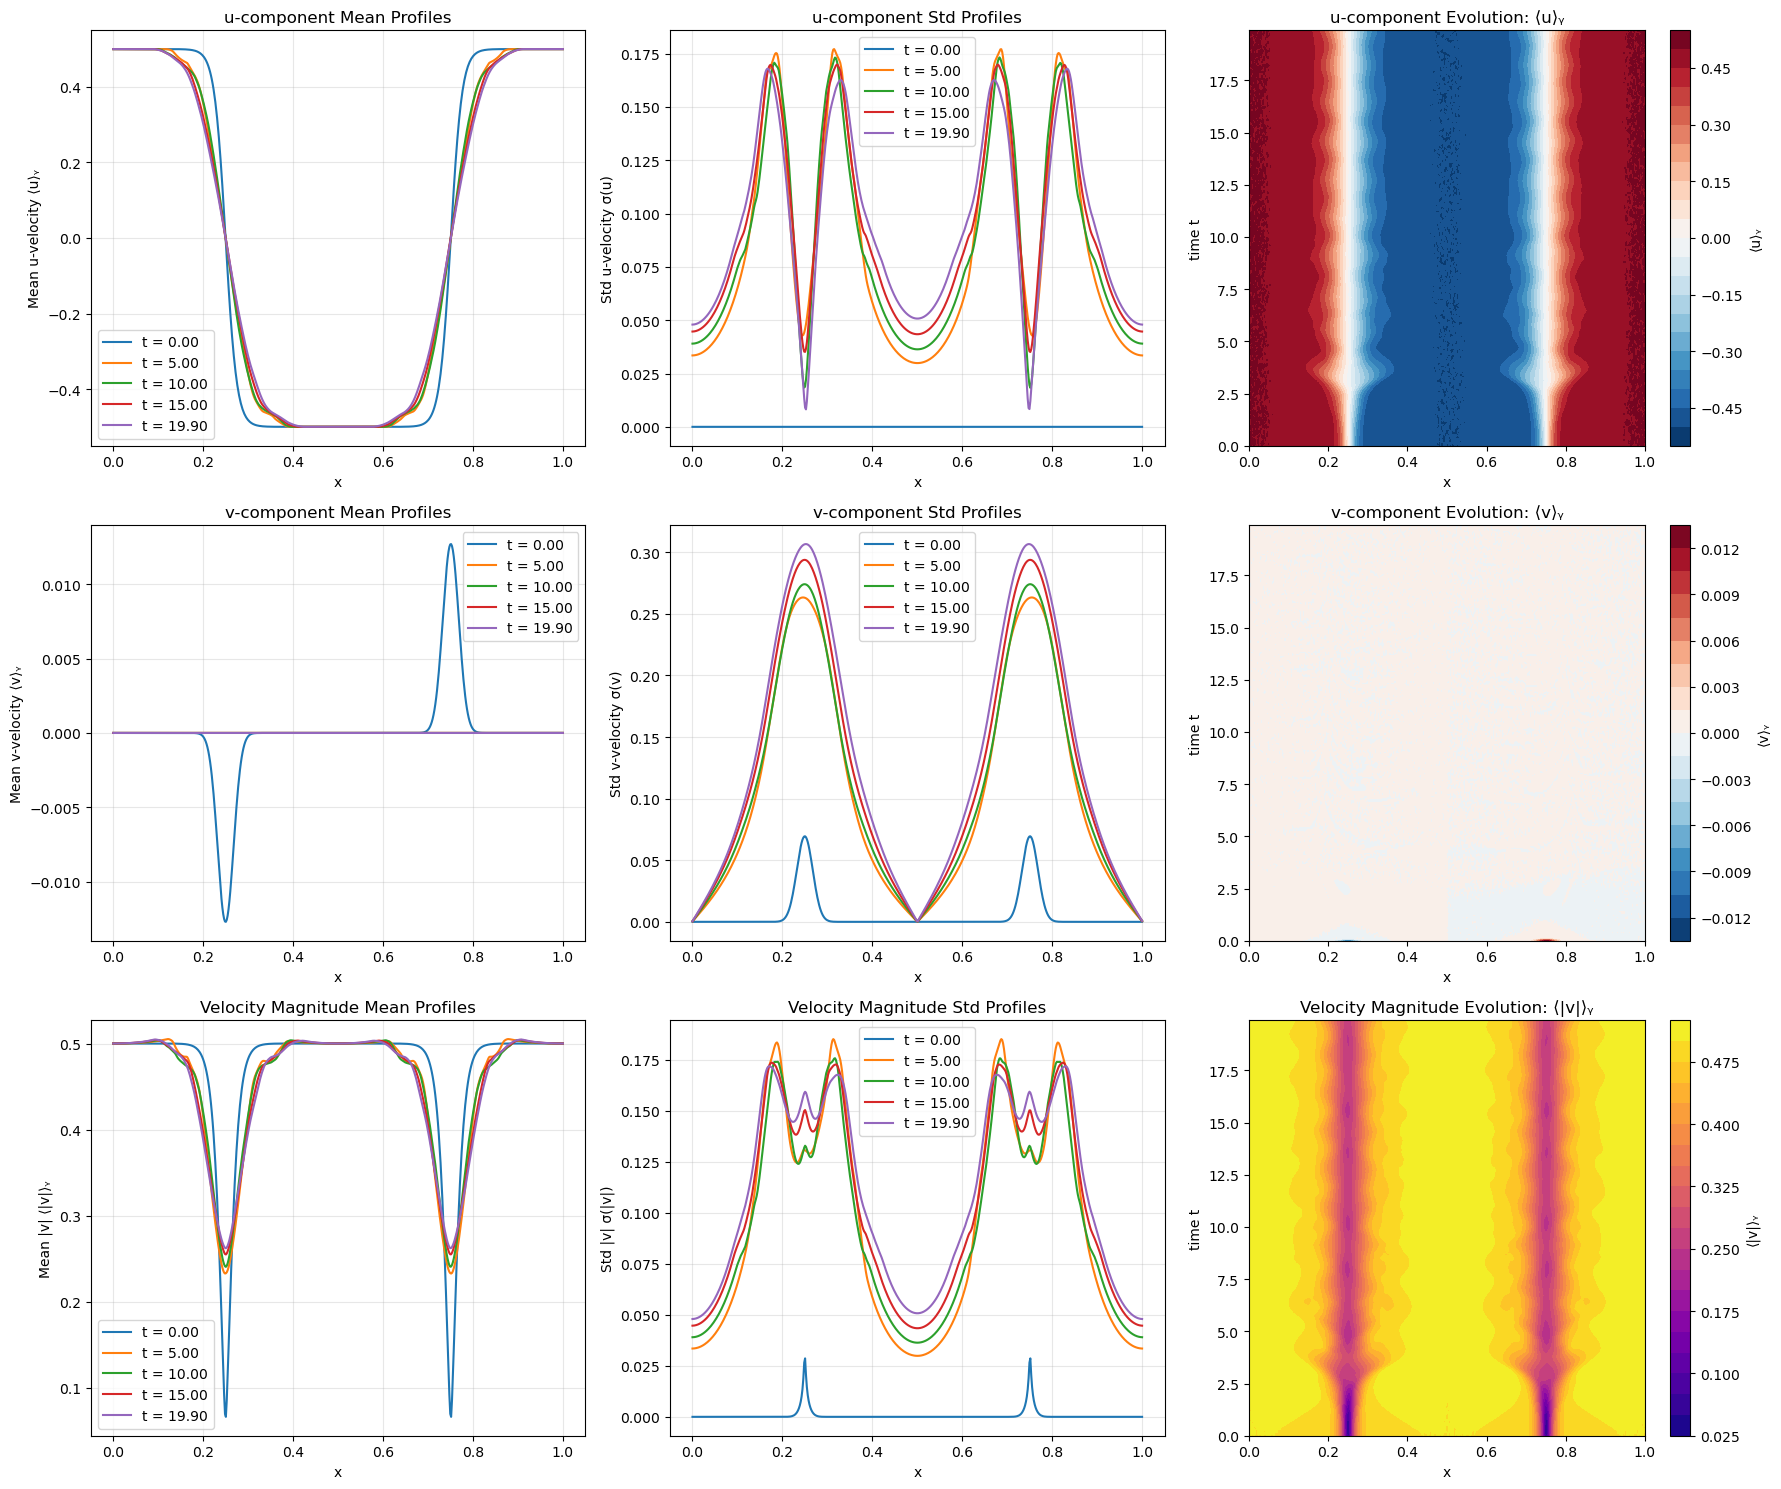

✓ Velocity visualization saved as 'velocity_profiles.png'


In [16]:
# Visualize the velocity 1D profiles
if velocity_x_mean_1d is not None:
    print("Creating velocity visualizations...")
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    
    time_indices = [0, 50, 100, 150, n_time-1]
    
    # Row 1: u-component (velocity in x-direction)
    # Plot 1: Mean u at different times
    ax = axes[0, 0]
    for t_idx in time_indices:
        ax.plot(x, velocity_x_mean_1d[t_idx, :], label=f't = {t[t_idx]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('Mean u-velocity ⟨u⟩ᵧ')
    ax.set_title('u-component Mean Profiles')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Std u at different times
    ax = axes[0, 1]
    for t_idx in time_indices:
        ax.plot(x, velocity_x_std_1d[t_idx, :], label=f't = {t[t_idx]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('Std u-velocity σ(u)')
    ax.set_title('u-component Std Profiles')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Heatmap of mean u evolution
    ax = axes[0, 2]
    im = ax.contourf(x, t, velocity_x_mean_1d, levels=20, cmap='RdBu_r')
    ax.set_xlabel('x')
    ax.set_ylabel('time t')
    ax.set_title('u-component Evolution: ⟨u⟩ᵧ')
    plt.colorbar(im, ax=ax, label='⟨u⟩ᵧ')
    
    # Row 2: v-component (velocity in y-direction)
    # Plot 4: Mean v at different times
    ax = axes[1, 0]
    for t_idx in time_indices:
        ax.plot(x, velocity_y_mean_1d[t_idx, :], label=f't = {t[t_idx]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('Mean v-velocity ⟨v⟩ᵧ')
    ax.set_title('v-component Mean Profiles')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Std v at different times
    ax = axes[1, 1]
    for t_idx in time_indices:
        ax.plot(x, velocity_y_std_1d[t_idx, :], label=f't = {t[t_idx]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('Std v-velocity σ(v)')
    ax.set_title('v-component Std Profiles')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 6: Heatmap of mean v evolution
    ax = axes[1, 2]
    im = ax.contourf(x, t, velocity_y_mean_1d, levels=20, cmap='RdBu_r')
    ax.set_xlabel('x')
    ax.set_ylabel('time t')
    ax.set_title('v-component Evolution: ⟨v⟩ᵧ')
    plt.colorbar(im, ax=ax, label='⟨v⟩ᵧ')
    
    # Row 3: Velocity magnitude
    # Plot 7: Mean |v| at different times
    ax = axes[2, 0]
    for t_idx in time_indices:
        ax.plot(x, velocity_mag_mean_1d[t_idx, :], label=f't = {t[t_idx]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('Mean |v| ⟨|v|⟩ᵧ')
    ax.set_title('Velocity Magnitude Mean Profiles')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 8: Std |v| at different times
    ax = axes[2, 1]
    for t_idx in time_indices:
        ax.plot(x, velocity_mag_std_1d[t_idx, :], label=f't = {t[t_idx]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('Std |v| σ(|v|)')
    ax.set_title('Velocity Magnitude Std Profiles')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 9: Heatmap of mean |v| evolution
    ax = axes[2, 2]
    im = ax.contourf(x, t, velocity_mag_mean_1d, levels=20, cmap='plasma')
    ax.set_xlabel('x')
    ax.set_ylabel('time t')
    ax.set_title('Velocity Magnitude Evolution: ⟨|v|⟩ᵧ')
    plt.colorbar(im, ax=ax, label='⟨|v|⟩ᵧ')
    
    plt.tight_layout()
    plt.savefig('velocity_profiles.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Velocity visualization saved as 'velocity_profiles.png'")
else:
    print("Skipping velocity profile visualization - data not available")

## Step 7: Save 1D Profiles to Disk

Save all the preprocessed 1D time series profiles for later use in machine learning models.

In [17]:
# Save all 1D profiles to a single compressed numpy file
import numpy as np

# Prepare metadata
metadata = {
    'Reynolds': Re,
    'Schmidt': Sc,
    'ic_index': ic_index,
    'n_time': n_time,
    'n_spatial': len(x),  # spatial points after averaging
    'time_range': [t[0], t[-1]],
    'x_range': [x[0], x[-1]]
}

# Prepare data dictionary
data_dict = {
    # Coordinates
    'time': t,
    'x': x,
    
    # Tracer/concentration fields
    'tracer_mean': tracer_mean_1d,
    'tracer_std': tracer_std_1d,
    
    # Metadata
    'Re': Re,
    'Sc': Sc,
    'ic_index': ic_index
}

# Add velocity fields if available
if velocity_x_mean_1d is not None:
    data_dict.update({
        'velocity_x_mean': velocity_x_mean_1d,
        'velocity_x_std': velocity_x_std_1d,
        'velocity_y_mean': velocity_y_mean_1d,
        'velocity_y_std': velocity_y_std_1d,
        'velocity_mag_mean': velocity_mag_mean_1d,
        'velocity_mag_std': velocity_mag_std_1d
    })

# Save to compressed numpy file
output_filename = f'shearflow_1d_profiles_Re{Re:.0e}_Sc{Sc:.1e}_ic{ic_index}.npz'
np.savez_compressed(output_filename, **data_dict)

print(f"✓ Saved 1D profiles to: {output_filename}")
print(f"\nSaved arrays:")
for key, value in data_dict.items():
    if isinstance(value, np.ndarray):
        print(f"  {key}: shape={value.shape}, dtype={value.dtype}")
    else:
        print(f"  {key}: {value}")

# Display file size
import os
file_size_mb = os.path.getsize(output_filename) / (1024**2)
print(f"\nFile size: {file_size_mb:.2f} MB")

✓ Saved 1D profiles to: shearflow_1d_profiles_Re5e+05_Sc2.0e-01_ic0.npz

Saved arrays:
  time: shape=(200,), dtype=float64
  x: shape=(512,), dtype=float32
  tracer_mean: shape=(200, 512), dtype=float32
  tracer_std: shape=(200, 512), dtype=float32
  Re: 500000.0
  Sc: 0.2
  ic_index: 0
  velocity_x_mean: shape=(200, 512), dtype=float32
  velocity_x_std: shape=(200, 512), dtype=float32
  velocity_y_mean: shape=(200, 512), dtype=float32
  velocity_y_std: shape=(200, 512), dtype=float32
  velocity_mag_mean: shape=(200, 512), dtype=float32
  velocity_mag_std: shape=(200, 512), dtype=float32

File size: 2.42 MB


### Loading Data as PyTorch Tensors

Example code snippet showing how to load the saved data and convert to PyTorch tensors for ML training:

In [18]:
# Example: Load data and convert to PyTorch tensors
import numpy as np
import torch

# Load the saved data
filename = f'shearflow_1d_profiles_Re{Re:.0e}_Sc{Sc:.1e}_ic{ic_index}.npz'
data = np.load(filename)

print(f"Loaded data from: {filename}")
print(f"Available keys: {list(data.keys())}")
print()

# Extract arrays
time = data['time']
x_coords = data['x']
tracer_mean = data['tracer_mean']
tracer_std = data['tracer_std']

# Convert to PyTorch tensors
time_tensor = torch.from_numpy(time).float()
x_tensor = torch.from_numpy(x_coords).float()
tracer_mean_tensor = torch.from_numpy(tracer_mean).float()
tracer_std_tensor = torch.from_numpy(tracer_std).float()

print("PyTorch tensors:")
print(f"  time: {time_tensor.shape}, dtype={time_tensor.dtype}")
print(f"  x: {x_tensor.shape}, dtype={x_tensor.dtype}")
print(f"  tracer_mean: {tracer_mean_tensor.shape}, dtype={tracer_mean_tensor.dtype}")
print(f"  tracer_std: {tracer_std_tensor.shape}, dtype={tracer_std_tensor.dtype}")

# Load velocity fields if available
if 'velocity_x_mean' in data:
    velocity_x_mean_tensor = torch.from_numpy(data['velocity_x_mean']).float()
    velocity_y_mean_tensor = torch.from_numpy(data['velocity_y_mean']).float()
    print(f"  velocity_x_mean: {velocity_x_mean_tensor.shape}, dtype={velocity_x_mean_tensor.dtype}")
    print(f"  velocity_y_mean: {velocity_y_mean_tensor.shape}, dtype={velocity_y_mean_tensor.dtype}")

# Example: Stack all features into a single tensor for ML training
# Shape will be (time_steps, spatial_points, n_features)
if 'velocity_x_mean' in data:
    # Stack: [tracer_mean, tracer_std, u_mean, u_std, v_mean, v_std]
    features = torch.stack([
        tracer_mean_tensor,
        tracer_std_tensor,
        torch.from_numpy(data['velocity_x_mean']).float(),
        torch.from_numpy(data['velocity_x_std']).float(),
        torch.from_numpy(data['velocity_y_mean']).float(),
        torch.from_numpy(data['velocity_y_std']).float()
    ], dim=-1)  # Stack along last dimension
    
    print(f"\nStacked features tensor: {features.shape}")
    print(f"  Format: (time={features.shape[0]}, spatial={features.shape[1]}, features={features.shape[2]})")
    print(f"  Features: [tracer_mean, tracer_std, u_mean, u_std, v_mean, v_std]")
else:
    # Only tracer data available
    features = torch.stack([
        tracer_mean_tensor,
        tracer_std_tensor
    ], dim=-1)
    
    print(f"\nStacked features tensor: {features.shape}")
    print(f"  Format: (time={features.shape[0]}, spatial={features.shape[1]}, features={features.shape[2]})")
    print(f"  Features: [tracer_mean, tracer_std]")

print("\n✓ Data ready for PyTorch ML pipeline!")

Loaded data from: shearflow_1d_profiles_Re5e+05_Sc2.0e-01_ic0.npz
Available keys: ['time', 'x', 'tracer_mean', 'tracer_std', 'Re', 'Sc', 'ic_index', 'velocity_x_mean', 'velocity_x_std', 'velocity_y_mean', 'velocity_y_std', 'velocity_mag_mean', 'velocity_mag_std']

PyTorch tensors:
  time: torch.Size([200]), dtype=torch.float32
  x: torch.Size([512]), dtype=torch.float32
  tracer_mean: torch.Size([200, 512]), dtype=torch.float32
  tracer_std: torch.Size([200, 512]), dtype=torch.float32
  velocity_x_mean: torch.Size([200, 512]), dtype=torch.float32
  velocity_y_mean: torch.Size([200, 512]), dtype=torch.float32

Stacked features tensor: torch.Size([200, 512, 6])
  Format: (time=200, spatial=512, features=6)
  Features: [tracer_mean, tracer_std, u_mean, u_std, v_mean, v_std]

✓ Data ready for PyTorch ML pipeline!
